Imports

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

Helper Functions

In [71]:
def one_hot(labels, num_classes):
    onehot = np.zeros((labels.shape[0], num_classes))
    onehot[np.arange(labels.shape[0]), labels] = 1
    return onehot

Import and Format Data

In [72]:
root = './data/'
train_images_filepath = root + 'train-images-idx3-ubyte/train-images-idx3-ubyte'
train_labels_filepath = root + 'train-labels-idx1-ubyte/train-labels-idx1-ubyte'
test_images_filepath = root + 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte'
test_labels_filepath = root + 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte'

def load_mnist_images(filepath):
    with open(filepath, 'rb') as f:
        raw_images = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)
    data = raw_images.reshape(raw_images.shape[0], -1) / 255.0
    return data

def load_mnist_labels(filepath):
    with open(filepath, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)
    return labels

train_images = load_mnist_images(train_images_filepath)
train_labels = load_mnist_labels(train_labels_filepath)
test_images = load_mnist_images(test_images_filepath)
test_labels = load_mnist_labels(test_labels_filepath)

train_labels_onehot = one_hot(train_labels, len(np.unique(train_labels)))
test_labels_onehot = one_hot(test_labels, len(np.unique(train_labels)))

Create an MLP Class

In [73]:
class mlp():
    def __init__(self, input_size, hidden_size, output_size, learning_rate, momentum=0.9, batch_size=64):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros(hidden_size)
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros(output_size)

        self.learning_rate = learning_rate
        self.momentum = momentum
        self.batch_size = batch_size
        self.train_loss = []
        self.validation_loss = []

        self.v_W1 = np.zeros_like(self.W1)
        self.v_b1 = np.zeros_like(self.b1)
        self.v_W2 = np.zeros_like(self.W2)
        self.v_b2 = np.zeros_like(self.b2)

    def sigmoid(self, s):
        return 1 / (1 + np.exp(-s))

    def sigmoidPrime(self, s):
        return self.sigmoid(s)*(1-self.sigmoid(s))
    
    def relu(self, x):
        return np.maximum(0, x)

    def reluPrime(self, x):
        return np.where(x > 0, 1, 0)
    
    def loss(self, y, yhat):
        epsilon = 1e-15
        cross_entropy = -np.mean(y * np.log(yhat + epsilon) + (1 - y) * np.log(1 - yhat + epsilon))
        return cross_entropy
    
    def forward_propagation(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2
    
    def backward_propagation(self, X, y, yhat):
        m = X.shape[1]
        self.dz2 = yhat - y
        self.dW2 = 1/m * np.dot(self.a1.T, self.dz2)
        self.db2 = 1/m * np.sum(self.dz2, axis=0)
        self.dz1 = np.dot(self.dz2, self.W2.T) * self.reluPrime(self.z1)
        self.dW1 = 1/m * np.dot(X.T, self.dz1)
        self.db1 = 1/m * np.sum(self.dz1, axis=0)
        self.v_W2 = self.momentum * self.v_W2 - self.learning_rate * self.dW2
        self.v_b2 = self.momentum * self.v_b2 - self.learning_rate * self.db2
        self.v_W1 = self.momentum * self.v_W1 - self.learning_rate * self.dW1
        self.v_b1 = self.momentum * self.v_b1 - self.learning_rate * self.db1
        self.W1 += self.v_W1
        self.b1 += self.v_b1
        self.W2 += self.v_W2
        self.b2 += self.v_b2

    def train(self, X, y, epochs):
        # Shuffle the data
        indices = np.random.permutation(X.shape[0])
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        # Split data into training and validation sets
        split_idx = int(X.shape[0]*0.8)
        X_tr = X_shuffled[:split_idx]
        X_val = X_shuffled[split_idx:]
        y_tr = y_shuffled[:split_idx] 
        y_val = y_shuffled[split_idx:]

        best_loss = float('inf')
        patience = 10
        wait = 0
        n_samples = X_tr.shape[0]
        for epoch in range(epochs):
            # Shuffle the data
            indices = np.random.permutation(n_samples)
            X_tr_shuffled = X_tr[indices]
            y_tr_shuffled = y_tr[indices]

            total_loss = 0
            for i in range(0, n_samples, self.batch_size):
                batch_end = min(i + self.batch_size, n_samples)
                X_batch = X_tr_shuffled[i:batch_end]
                y_batch = y_tr_shuffled[i:batch_end]

                # Forward and backward pass for the batch
                yhat = self.forward_propagation(X_batch)
                self.backward_propagation(X_batch, y_batch, yhat)
                total_loss += self.loss(y_batch, yhat) * (batch_end - i)

            # Average loss for the epoch
            avg_loss = total_loss / n_samples
            self.train_loss.append(avg_loss)
            
            # Compute the validation loss
            self.forward_propagation(X_val)
            val_loss = self.loss(y_val, self.a2)
            self.validation_loss.append(val_loss)
            
            if epoch % 10 == 0:
                print(f'Epoch {epoch}/{epochs} - loss: {avg_loss}')

            if val_loss < best_loss:
                best_loss = val_loss
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

    def plot_loss(self):
        fig, ax = plt.subplots(figsize=(5,5))
        ax.plot(range(len(self.train_loss)), self.train_loss, 'b-', label='Training Loss')
        ax.plot(range(len(self.validation_loss)), self.validation_loss, 'r-', label='Validation Loss')
        ax.set_title("Error rate as a function of epochs")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.grid(True)
        ax.legend()
        plt.show()

Train the mlp

Epoch 0/1000 - loss: 0.20567351613170212
Epoch 10/1000 - loss: 0.05262813725966166
Epoch 20/1000 - loss: 0.039386658650124494
Epoch 30/1000 - loss: 0.03226485783258424
Epoch 40/1000 - loss: 0.02760017205285794
Epoch 50/1000 - loss: 0.024242075646371507
Epoch 60/1000 - loss: 0.021644864235327986
Epoch 70/1000 - loss: 0.01957957494695777
Epoch 80/1000 - loss: 0.01787213767737581
Epoch 90/1000 - loss: 0.016432090834693828
Epoch 100/1000 - loss: 0.015206768508679315
Epoch 110/1000 - loss: 0.014148831423447483
Epoch 120/1000 - loss: 0.013201549107586115
Epoch 130/1000 - loss: 0.01237464199129863
Epoch 140/1000 - loss: 0.011638115671008262
Epoch 150/1000 - loss: 0.010959488588099638
Epoch 160/1000 - loss: 0.010352431279540188
Epoch 170/1000 - loss: 0.00979563717840715
Epoch 180/1000 - loss: 0.00927622061521777
Epoch 190/1000 - loss: 0.008808003271912591
Epoch 200/1000 - loss: 0.008362986308150636
Epoch 210/1000 - loss: 0.007960057962727234
Epoch 220/1000 - loss: 0.007580722019136557
Epoch 23

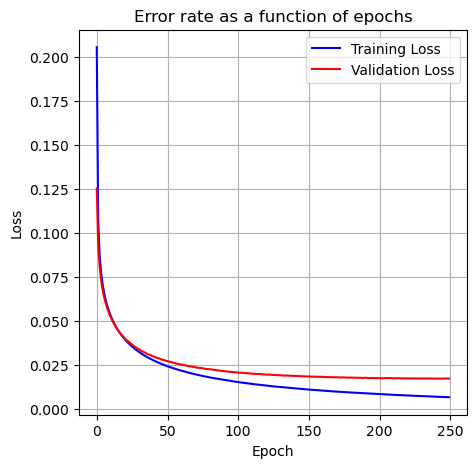

In [74]:
X_tr = train_images
y_tr = train_labels_onehot
X_te = test_images
y_te = test_labels_onehot

input_size = X_tr.shape[1]
hidden_size = 128
output_size = len(np.unique(train_labels))
learning_rate = 0.01
num_epoch = 1000

NN = mlp(input_size, hidden_size, output_size, learning_rate)
NN.train(X_tr, y_tr, num_epoch)
NN.plot_loss()

Apply results to unseen data and compute performance

Test accuracy: 0.9782


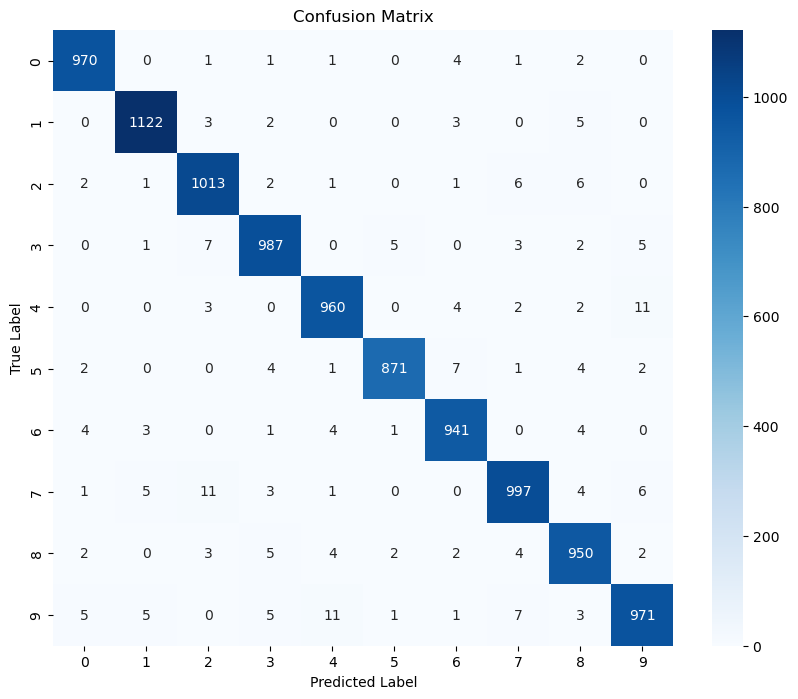

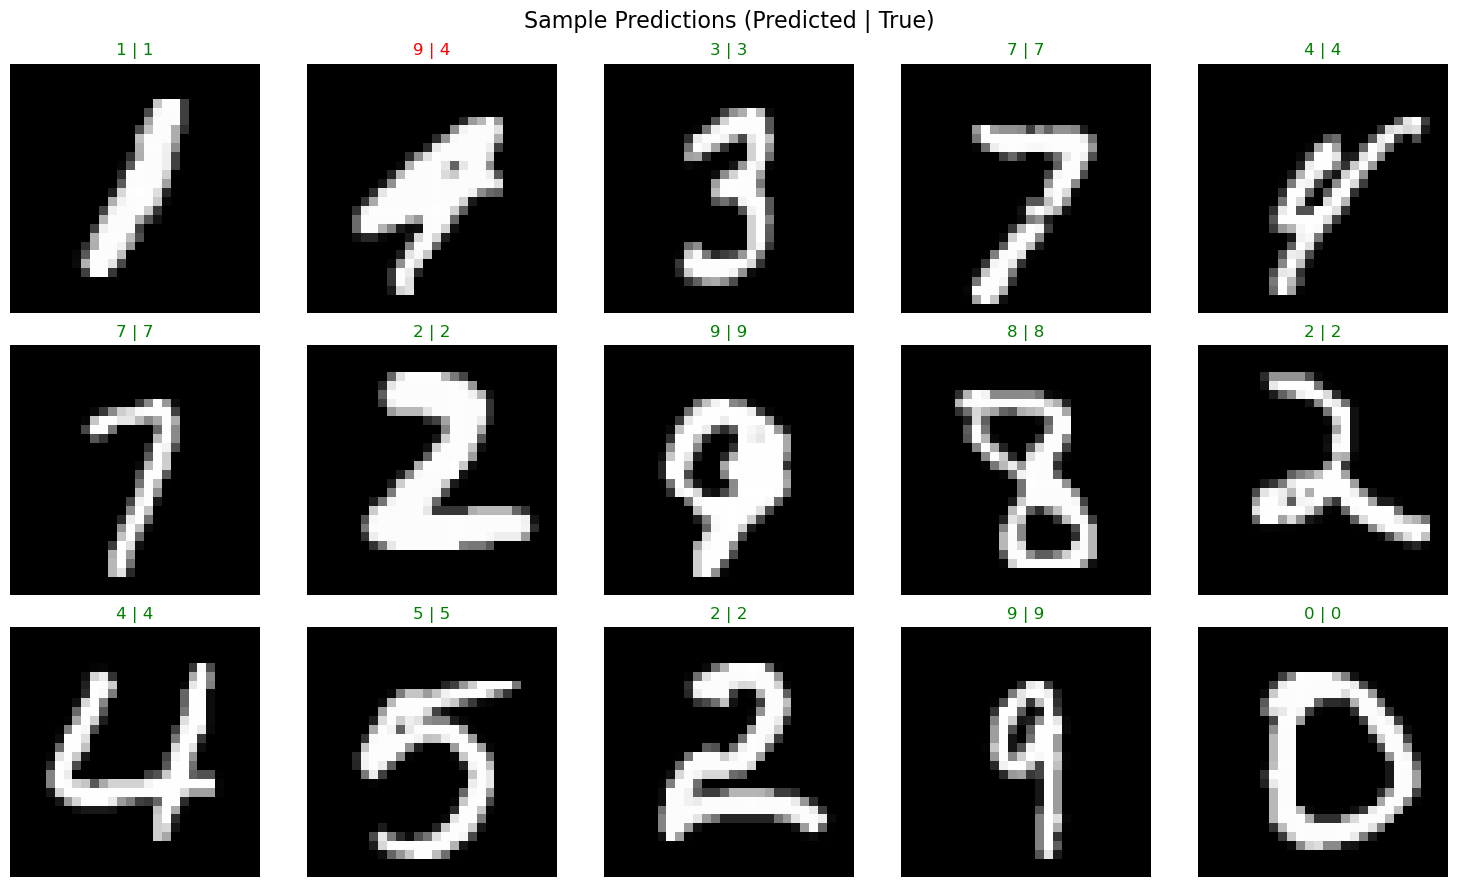

In [75]:
# Make predictions on test data
test_predictions = NN.forward_propagation(test_images)
predicted_labels = np.argmax(test_predictions, axis=1)

# Calculate accuracy
accuracy = np.mean(predicted_labels == test_labels)
print(f"Test accuracy: {accuracy:.4f}")

# Create a confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Visualize some examples
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Sample Predictions (Predicted | True)', fontsize=16)

# Get random indices to visualize
samples = np.random.randint(0, len(test_images), 15)

for i, ax in enumerate(axes.flat):
    # Get sample index
    idx = samples[i]
    
    # Display image
    ax.imshow(test_images[idx].reshape(28, 28), cmap='gray')
    
    # Display prediction vs true label
    pred_label = predicted_labels[idx]
    true_label = test_labels[idx]
    ax.set_title(f"{pred_label} | {true_label}", 
                color='green' if pred_label == true_label else 'red')
    ax.axis('off')

plt.tight_layout()
plt.show()